In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time
import gc
import pathlib

In [2]:
save_plots = True

## Create plots directory, if missing
plotsDirectory = '/home/adegenna/vertex-reconstruction-studies/plots/reco_efficiency/'
pathlib.Path(plotsDirectory).mkdir(parents=True, exist_ok=True)

# $\Lambda^0_b \rightarrow J/\psi (\rightarrow \mu^+\mu^-) \Lambda^0 (\rightarrow p\pi^-)$
## Import MC data

In [3]:
inputMC = '~/data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

In [4]:
tick = time.perf_counter()
df_MC_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tock = time.perf_counter()
print(f"Monte Carlo imported in {tock - tick:0.4f} seconds.")

Monte Carlo imported in 1.3189 seconds.


In [5]:
tick = time.perf_counter()
df_MC_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tock = time.perf_counter()
print(f"Monte Carlo Truth imported in {tock - tick:0.4f} seconds.")

Monte Carlo Truth imported in 14.1701 seconds.


In [6]:
tick = time.perf_counter()
df_MC = pd.merge(df_MC_truth, df_MC_reco.loc[df_MC_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')
tock = time.perf_counter()
print(f"Monte Carlo merged in {tock - tick:0.4f} seconds.")

Monte Carlo merged in 154.6571 seconds.


In [7]:
## Cut on true Lambda decay vertex. 8000 is the maximum to have events,
## no Lambda in the MC decays farther than that.
LambdaZVertexLowerBound = 0
LambdaZVertexUpperBound = 8000
df_MC = df_MC[(df_MC['MCTRUTH_L_ENDVERTEX_Z'] > LambdaZVertexLowerBound) & (df_MC['MCTRUTH_L_ENDVERTEX_Z'] < LambdaZVertexUpperBound)]
df_MC

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_pim_PZ,DTF_FixJPsiLambda_PIDSubs_p_PX,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ
MC_key,,,,,,,,,,,,,,,,,,,,,
0,0.9512,-0.1669,26.401600,343.742889,-192.429398,4751.548828,2031.640015,-1218.119995,29336.890625,445.510010,...,32905.289062,292.816681,-186.566345,5411.963379,-804.469727,-535.944397,22858.960938,1438.071777,1619.34729,23634.302734
1,0.4619,-0.3471,-52.081200,-19.765400,-33.384300,45.136002,-1190.050049,-1817.560059,5618.410156,-125.169998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.8623,-0.0693,39.078201,145.114395,-70.015701,2563.685059,1349.000000,-574.190002,22276.189453,239.940002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.8441,-0.1694,17.714300,-9.207400,27.546700,3520.887207,-295.320007,790.229980,93841.296875,3.170000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.6610,-0.4327,7.083600,-23.592199,-54.290798,201.384293,-1843.489990,-4303.959961,15525.910156,-361.470001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8921810,0.7382,-0.1062,0.347100,-2.454600,0.459400,68.980499,-1052.079956,169.649994,21721.480469,-270.470001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921811,0.6401,-0.0814,27.420200,4.920900,-10.475100,58.229698,680.200012,-1542.880005,4852.310059,153.279999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8921812,2.0908,-1.0901,46.602200,36.268501,-29.632999,1175.768677,4569.680176,-3904.929932,153438.671875,582.070007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
## Cleanup
del(df_MC_truth)
del(df_MC_reco)
gc.collect()

36

## Combined $\Lambda^0$ and $\Lambda_b^0$ reconstruction efficiencies
Here it is assumed that $J/\psi$ reconstruction never fails, which is sort of true.

In [9]:
## Select reconstructed muons. There is a very small (~4500) number of reconstructed events
## where the 'PID_Reconstructed' variables do not match the corresponding 'PID_Reconstructible'.
reconstructibleMuons = (df_MC['mum_Reconstructible']=='ChargedLong') & (df_MC['mup_Reconstructible']=='ChargedLong')
reconstructedMuons = (df_MC['mum_Reconstructed']=='ChargedLong') & (df_MC['mup_Reconstructed']=='ChargedLong')

## The mismatched events here are a bit more (~11k). I suppose this could be because of particles
## potentially reconstructible as something "better" than TTRACKS (e.g. LONG) that get a degreaded result.
reconstructibleTTracks = (df_MC['pim_Reconstructible']=='ChargedTtrack') & (df_MC['p_Reconstructible']=='ChargedTtrack')
reconstructedTTracks = (df_MC['pim_Reconstructed']=='ChargedTtrack') & (df_MC['p_Reconstructed']=='ChargedTtrack')

reconstructibleLambda = (df_MC['L_Reconstructible']=='Neutral')
reconstructibleLambdab = (df_MC['Lb_Reconstructible']=='Neutral')

## This selects all events actually reconstructed in the MC_reco. Since we have constrained reconstruction
## of muons, protons and pions, the deficit must be due to Lambda and/or Lambdab reconstrution failure.
## (Or J/psi, sure, but we assume that two LONG muons are tracked much better than two TTRACKS proton and pions.)
allReconstructedEvents = ((df_MC['Rec_key'] >= 0) & (df_MC['TrackType'] == 'T'))

In [10]:
selectionCandidates = (
    reconstructibleMuons & reconstructedMuons
    & reconstructibleTTracks & reconstructedTTracks
#    & reconstructibleLambda & reconstructibleLambdab
)
    
selectionPassed = selectionCandidates & allReconstructedEvents

In [11]:
binning = np.linspace(LambdaZVertexLowerBound, LambdaZVertexUpperBound, 40)
LambdaZTrueDecayVertices = df_MC['MCTRUTH_L_ENDVERTEX_Z']

binnedCandidates, _ = np.histogram(LambdaZTrueDecayVertices[selectionCandidates], bins=binning)
binnedPassed, _ = np.histogram(LambdaZTrueDecayVertices[selectionPassed], bins=binning)

binnedEfficiencies = binnedPassed / binnedCandidates
binnedEfficiencyErrors = np.sqrt((binnedEfficiencies * (1- binnedEfficiencies)) / (binnedCandidates))

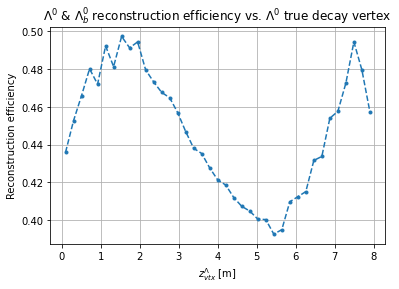

In [12]:
binningMidpoints = (binning[1:] + binning[:-1]) / 2

plt.plot(binningMidpoints/1000, binnedEfficiencies, color='tab:blue', linestyle='--', marker='.')
plt.xlabel("$z_{vtx}^\Lambda$ [m]")
plt.ylabel("Reconstruction efficiency")
plt.title("$\Lambda^0$ & $\Lambda_b^0$ reconstruction efficiency vs. $\Lambda^0$ true decay vertex")
plt.grid()
if save_plots:
    plt.savefig(plotsDirectory + 'lambda_lambdab_reco_efficiency.pdf', bbox_inches='tight')
plt.show()

In [13]:
print("z\t\tcandidates\treco\tefficiency\terror")
for midpoint, candidates, passed, efficiency, error in zip(
    binningMidpoints, binnedCandidates, binnedPassed, binnedEfficiencies, binnedEfficiencyErrors
):
    print("".join("{:.2f}\t\t{}\t\t{}\t{:.3f}\t\t{:.3f}".format(
        midpoint,
        candidates,
        passed,
        efficiency,
        error
    )))

z		candidates	reco	efficiency	error
102.56		1764		769	0.436		0.012
307.69		1975		894	0.453		0.011
512.82		1848		861	0.466		0.012
717.95		2954		1418	0.480		0.009
923.08		3168		1495	0.472		0.009
1128.21		2343		1153	0.492		0.010
1333.33		2153		1036	0.481		0.011
1538.46		2086		1037	0.497		0.011
1743.59		2083		1023	0.491		0.011
1948.72		2173		1074	0.494		0.011
2153.85		2340		1122	0.479		0.010
2358.97		19283		9123	0.473		0.004
2564.10		39750		18586	0.468		0.003
2769.23		41322		19205	0.465		0.002
2974.36		37799		17270	0.457		0.003
3179.49		35473		15853	0.447		0.003
3384.62		32909		14416	0.438		0.003
3589.74		30742		13382	0.435		0.003
3794.87		28923		12370	0.428		0.003
4000.00		27707		11674	0.421		0.003
4205.13		26236		10984	0.419		0.003
4410.26		25242		10401	0.412		0.003
4615.38		24138		9834	0.407		0.003
4820.51		23292		9431	0.405		0.003
5025.64		22509		9019	0.401		0.003
5230.77		21650		8669	0.400		0.003
5435.90		21027		8258	0.393		0.003
5641.03		20502		8100	0.395		0.003
5846.15		19406		7953	

In an ideal world, one would further separate $\Lambda_0$ and $\Lambda_0^b$ efficiency failures based on the `Reconstructed` variables. Unfortunately...

In [14]:
df_MC['Lb_Reconstructed'].unique()

['NotReconstructed']
Categories (1, object): ['NotReconstructed']

In [15]:
df_MC['L_Reconstructed'].unique()

['NotReconstructed']
Categories (1, object): ['NotReconstructed']

Not a prerogative of T-Tracks related particles, either.

In [16]:
df_MC['Jpsi_Reconstructed'].unique()

['NotReconstructed']
Categories (1, object): ['NotReconstructed']

# $B^0 \rightarrow J/\psi (\rightarrow \mu^+\mu^-) K^0_S(\rightarrow \pi^+\pi^-)$
## Import MC data

In [17]:
inputMC = '~/data/LHCbMC_2016-2017-2018_MagUpDown_B2JPsiK_Ttracks_v6.h5'

In [18]:
tick = time.perf_counter()
df_MC_reco = pd.read_hdf(inputMC, key='LHCbMC_B0')
tock = time.perf_counter()
print(f"Monte Carlo imported in {tock - tick:0.4f} seconds.")

Monte Carlo imported in 0.4400 seconds.


In [19]:
tick = time.perf_counter()
df_MC_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_B0')
tock = time.perf_counter()
print(f"Monte Carlo Truth imported in {tock - tick:0.4f} seconds.")

Monte Carlo Truth imported in 10.6115 seconds.


In [20]:
tick = time.perf_counter()
df_MC = pd.merge(df_MC_truth, df_MC_reco.loc[df_MC_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')
tock = time.perf_counter()
print(f"Monte Carlo merged in {tock - tick:0.4f} seconds.")

Monte Carlo merged in 102.1470 seconds.


In [21]:
KS0ZVertexLowerBound = 0
KS0ZVertexUpperBound = 8000
df_MC = df_MC[
    (df_MC['MCTRUTH_KS0_ENDVERTEX_Z'] > KS0ZVertexLowerBound)
    & (df_MC['MCTRUTH_KS0_ENDVERTEX_Z'] < KS0ZVertexUpperBound)]
df_MC

,MCTRUTH_B0_ENDVERTEX_X,MCTRUTH_B0_ENDVERTEX_Y,MCTRUTH_B0_ENDVERTEX_Z,MCTRUTH_KS0_ENDVERTEX_X,MCTRUTH_KS0_ENDVERTEX_Y,MCTRUTH_KS0_ENDVERTEX_Z,MCTRUTH_pip_PX,MCTRUTH_pip_PY,MCTRUTH_pip_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiKaon_PIDSubs_pim_PZ,DTF_FixJPsiKaon_PIDSubs_pip_PX,DTF_FixJPsiKaon_PIDSubs_pip_PY,DTF_FixJPsiKaon_PIDSubs_pip_PZ,DTF_FixJPsiKaon_PIDSubs_mum_PX,DTF_FixJPsiKaon_PIDSubs_mum_PY,DTF_FixJPsiKaon_PIDSubs_mum_PZ,DTF_FixJPsiKaon_PIDSubs_mup_PX,DTF_FixJPsiKaon_PIDSubs_mup_PY,DTF_FixJPsiKaon_PIDSubs_mup_PZ
MC_key,,,,,,,,,,,,,,,,,,,,,
0,0.4864,0.0393,17.688801,-17.838699,31.001200,1540.456055,-715.599976,1456.510010,61921.261719,-522.849976,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.8422,-0.0882,4.923600,-11.957000,12.349800,217.799698,-968.419983,1152.150024,17645.210938,-394.549988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.2859,0.0505,-13.598600,75.121002,209.081604,4393.343750,583.880005,1038.829956,22917.589844,222.190002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.7288,-0.3998,-20.649099,-58.431499,-3.972900,313.157410,-946.650024,-229.690002,4776.669922,-986.140015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.5984,-0.1680,22.965599,-32.072899,88.717102,299.092804,-566.729980,1590.390015,5024.930176,-86.220001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6878845,0.7943,0.1800,-52.271702,-106.560997,255.741592,3063.681152,-78.089996,215.770004,3857.719971,-775.039978,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6878846,0.2053,0.2199,-11.981800,-0.447000,0.446100,0.946600,-202.000000,-30.190001,118.980003,181.919998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6878847,2.8503,-2.1199,-13.416300,21.202000,-208.085403,1945.437256,-60.820000,-1405.660034,13414.910156,246.839996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
## Cleanup
del(df_MC_truth)
del(df_MC_reco)
gc.collect()

3933

## Combined $B^0$ and $K_S^0$ reconstruction efficiencies
Here it is assumed that $J/\psi$ reconstruction never fails, which is sort of true.

In [23]:
reconstructibleMuons = (df_MC['mum_Reconstructible']=='ChargedLong') & (df_MC['mup_Reconstructible']=='ChargedLong')
reconstructedMuons = (df_MC['mum_Reconstructed']=='ChargedLong') & (df_MC['mup_Reconstructed']=='ChargedLong')

reconstructibleTTracks = (df_MC['pim_Reconstructible']=='ChargedTtrack') & (df_MC['pip_Reconstructible']=='ChargedTtrack')
reconstructedTTracks = (df_MC['pim_Reconstructed']=='ChargedTtrack') & (df_MC['pip_Reconstructed']=='ChargedTtrack')

allReconstructedEvents = ((df_MC['Rec_key'] >= 0) & (df_MC['TrackType'] == 'T'))

In [24]:
selectionCandidates = (
    reconstructibleMuons & reconstructedMuons
    & reconstructibleTTracks & reconstructedTTracks
)
    
selectionPassed = selectionCandidates & allReconstructedEvents

In [25]:
binning = np.linspace(KS0ZVertexLowerBound, KS0ZVertexUpperBound, 40)
KS0ZTrueDecayVertices = df_MC['MCTRUTH_KS0_ENDVERTEX_Z']

binnedCandidates, _ = np.histogram(KS0ZTrueDecayVertices[selectionCandidates], bins=binning)
binnedPassed, _ = np.histogram(KS0ZTrueDecayVertices[selectionPassed], bins=binning)

binnedEfficiencies = binnedPassed / binnedCandidates
binnedEfficiencyErrors = np.sqrt((binnedEfficiencies * (1- binnedEfficiencies)) / (binnedCandidates))

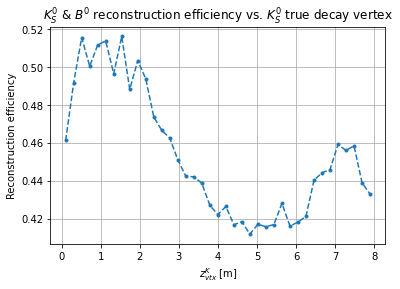

In [26]:
binningMidpoints = (binning[1:] + binning[:-1]) / 2

plt.plot(binningMidpoints/1000, binnedEfficiencies, color='tab:blue', linestyle='--', marker='.')
plt.xlabel("$z_{vtx}^K$ [m]")
plt.ylabel("Reconstruction efficiency")
plt.title("$K^0_S$ & $B^0$ reconstruction efficiency vs. $K^0_S$ true decay vertex")
plt.grid()
if save_plots:
    plt.savefig(plotsDirectory + 'KS0_B0_reco_efficiency.pdf', bbox_inches='tight')
plt.show()

In [27]:
print("z\t\tcandidates\treco\tefficiency\terror")
for midpoint, candidates, passed, efficiency, error in zip(
    binningMidpoints, binnedCandidates, binnedPassed, binnedEfficiencies, binnedEfficiencyErrors
):
    print("".join("{:.2f}\t\t{}\t\t{}\t{:.3f}\t\t{:.3f}".format(
        midpoint,
        candidates,
        passed,
        efficiency,
        error
    )))

z		candidates	reco	efficiency	error
102.56		709		327	0.461		0.019
307.69		1013		498	0.492		0.016
512.82		1104		569	0.515		0.015
717.95		1741		871	0.500		0.012
923.08		1816		929	0.512		0.012
1128.21		1612		828	0.514		0.012
1333.33		1495		742	0.496		0.013
1538.46		1593		822	0.516		0.013
1743.59		1512		738	0.488		0.013
1948.72		1518		764	0.503		0.013
2153.85		1578		779	0.494		0.013
2358.97		15263		7229	0.474		0.004
2564.10		30531		14243	0.467		0.003
2769.23		30501		14106	0.462		0.003
2974.36		27462		12387	0.451		0.003
3179.49		24665		10910	0.442		0.003
3384.62		23033		10182	0.442		0.003
3589.74		20935		9184	0.439		0.003
3794.87		19366		8270	0.427		0.004
4000.00		17875		7546	0.422		0.004
4205.13		16955		7230	0.426		0.004
4410.26		15816		6592	0.417		0.004
4615.38		14836		6208	0.418		0.004
4820.51		14053		5788	0.412		0.004
5025.64		13415		5595	0.417		0.004
5230.77		12567		5225	0.416		0.004
5435.90		12204		5088	0.417		0.004
5641.03		11339		4854	0.428		0.005
5846.15		11083		4612	0.416		0.005
6